In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

/home/jupyter/map-ephys


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one

foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

cache_folder = '~/s3-drive/report/st_cache/'

[2023-03-30 19:03:28,033][INFO]: Connecting map-superuser@datajoint.mesoscale-activity-map.org:3306
[2023-03-30 19:03:28,074][INFO]: Connected map-superuser@datajoint.mesoscale-activity-map.org:3306


# Export cache tables for streamlit app

## All foraging sessions

In [192]:
insertion_numbers = foraging_sessions.aggr(foraging_sessions * ephys.ProbeInsertion, ..., 
                                                #   keep_all_rows=True, ephys_insertions='IF(COUNT(insertion_number), "yes", "no")')
                                            keep_all_rows=True, ephys_ins='COUNT(insertion_number)')
if_histology = foraging_sessions.aggr(foraging_sessions * histology.ElectrodeCCFPosition.ElectrodePosition, ...,
                                    keep_all_rows=True, histology='IF(COUNT(ccf_x)>0, "yes", "no")')
if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                    keep_all_rows=True, photostim_behav='IF(COUNT(trial)>0, "yes", "no")')
if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                    keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

df_sessions = pd.DataFrame(((experiment.Session & foraging_sessions)
                            * lab.WaterRestriction.proj(h2o='water_restriction_number')
                            * insertion_numbers
                            * if_histology
                            * if_photostim_from_behav
                            * if_photostim_from_ephys)
                        .proj(..., '-rig', '-username', '-session_time')
                        .fetch()
                            )


,subject_id,session,session_date,h2o,ephys_ins,histology,photostim_behav,photostim_NI
0,447921,38,2019-11-01,HC16,0,no,no,no
1,447921,37,2019-10-31,HC16,0,no,no,no
2,447921,36,2019-10-30,HC16,0,no,no,no
3,447921,35,2019-10-29,HC16,0,no,no,no
4,447921,34,2019-10-28,HC16,0,no,no,no
...,...,...,...,...,...,...,...,...
2833,661100,5,2023-02-13,XY_21,0,no,no,no
2834,661100,4,2023-02-10,XY_21,0,no,no,no
2835,661100,3,2023-02-09,XY_21,0,no,no,no
2836,661100,2,2023-02-08,XY_21,0,no,no,no


In [233]:
foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol in (100, 110, 120)').proj()
insertion_numbers = foraging_sessions.aggr(foraging_sessions * ephys.ProbeInsertion, ..., 
                                                #   keep_all_rows=True, ephys_insertions='IF(COUNT(insertion_number), "yes", "no")')
                                            keep_all_rows=True, ephys_ins='COUNT(insertion_number)')
if_histology = foraging_sessions.aggr(foraging_sessions * histology.ElectrodeCCFPosition.ElectrodePosition, ...,
                                    keep_all_rows=True, histology='IF(COUNT(ccf_x)>0, "yes", "no")')
if_photostim_from_behav = foraging_sessions.aggr(foraging_sessions * experiment.PhotostimForagingTrial, ...,
                                    keep_all_rows=True, photostim='IF(COUNT(trial)>0, "yes", "no")')
if_photostim_from_ephys = foraging_sessions.aggr(foraging_sessions * (ephys.TrialEvent & 'trial_event_type LIKE "laser%"'), ...,
                                    keep_all_rows=True, photostim_NI='IF(COUNT(trial)>0, "yes", "no")')

df_sessions = pd.DataFrame(((experiment.Session & foraging_sessions)
                            * lab.WaterRestriction.proj(h2o='water_restriction_number')
                            * insertion_numbers
                            * if_histology
                            * if_photostim_from_behav
                            * if_photostim_from_ephys)
                        .proj(..., '-rig', '-username', '-session_time')
                        .fetch()
                            )

# df_sessions['session_date'] = pd.to_datetime(df_sessions['session_date'], format="%Y-%m-%d")

# add task protocol
df_session_stats = pd.DataFrame((foraging_analysis.SessionStats.proj(
                                                                    finished='session_pure_choices_num', 
                                                                    foraging_eff='session_foraging_eff_optimal',
                                                                    foraging_eff_randomseed='session_foraging_eff_optimal_random_seed',
                                                                    reward_rate='session_hit_num / session_total_trial_num',
                                                                    miss_rate='session_miss_num / session_total_trial_num',
                                                                    ignore_rate='session_ignore_num / session_total_trial_num',
                                                                    early_lick_ratio='session_early_lick_ratio',
                                                                    double_dipping_ratio='session_double_dipping_ratio',
                                                                    block_num='session_block_num',
                                                                    block_length='session_total_trial_num / session_block_num',
                                                                    mean_reward_sum='session_mean_reward_sum',
                                                                    mean_reward_contrast='session_mean_reward_contrast',
                                                                    autowater_num='session_autowater_num',
                                                                    length='session_length',
                                                                    )
                                * foraging_analysis.SessionTaskProtocol.proj(task='session_task_protocol', not_pretrain='session_real_foraging')
                                * foraging_analysis.SessionEngagementControl.proj(valid_trial_start='start_trial',
                                                                                valid_trial_end='end_trial',
                                                                                valid_ratio='valid_ratio',
                                                                                )
                                & foraging_sessions).fetch())

df_session_stats.foraging_eff[df_session_stats.foraging_eff_randomseed.notna()] = df_session_stats.foraging_eff_randomseed[df_session_stats.foraging_eff_randomseed.notna()]
df_session_stats.drop('foraging_eff_randomseed', axis=1, inplace=True)
df_session_stats['task'].replace({100: 'coupled_block_baiting', 110: 'decoupled_no_baiting', 120: 'random_walk'}, inplace=True)


# add photostim meta info
df_photostim = pd.DataFrame(experiment.PhotostimForagingLocation.fetch())
df_photostim_trial = pd.DataFrame(experiment.PhotostimForagingTrial.fetch())
df_photostim = df_photostim.merge(df_photostim_trial.groupby(['subject_id', 'session']).power.median(), how='left', on=('subject_id', 'session')
                                ).merge(df_photostim_trial.groupby(['subject_id', 'session'])['bpod_timer_align_to', 'bpod_timer_offset', 'ramping_down'].agg(pd.Series.mode).astype(str), how='left', on=('subject_id', 'session'))
df_photostim.rename({'power': 'laser_power_median', 'ramping_down': 'laser_ramping_down', 'bpod_timer_align_to': 'laser_aligned_to'}, axis=1)

#TODO: laser ratio and median inter_S_interval


# Merge all tables
df_sessions = df_sessions.merge(df_photostim.query('side == "left"').drop('side', axis=1), how='left', on=('subject_id', 'session')
                            ).merge(df_session_stats, how='left', on=('subject_id', 'session')
                            ).rename(columns={'location': 'photostim_location'})

# formatting
to_int = ['ephys_ins', *[col for col in df_sessions if 'num' in col], 'valid_trial_start', 'valid_trial_end']
for col in to_int:
    df_sessions[col] = df_sessions[col].astype('Int64')
    
# reorder
#df_sessions = reorder_df(df_sessions, 'h2o', 3)
for name, order in (('finished', 4), 
                    ('foraging_eff', 5),
                    ('photostim', 6),
                    ('task', 7),
                   ):
    df_sessions = reorder_df(df_sessions, name, order)


In [217]:
col

'valid_ratio'

In [202]:
df_photostim_trial = pd.DataFrame(experiment.PhotostimForagingTrial.fetch())
df_photostim_trial.groupby(['subject_id', 'session']).power.median()

subject_id  session
494691      19         2.000
494694      11         3.846
            12         7.778
            13         7.778
            14         7.778
                       ...  
656057      15         3.000
            16         3.000
656058      12         1.200
            14         1.200
            15         1.200
Name: power, Length: 94, dtype: float64

In [236]:
df_sessions.columns

Index(['subject_id', 'session', 'session_date', 'h2o', 'finished',
       'foraging_eff', 'photostim', 'task', 'ephys_ins', 'histology',
       'photostim_NI', 'photostim_location', 'power', 'bpod_timer_align_to',
       'bpod_timer_offset', 'ramping_down', 'block_num', 'early_lick_ratio',
       'autowater_num', 'length', 'double_dipping_ratio', 'mean_reward_sum',
       'mean_reward_contrast', 'reward_rate', 'miss_rate', 'ignore_rate',
       'block_length', 'not_pretrain', 'valid_trial_start', 'valid_trial_end',
       'valid_ratio'],
      dtype='object')

In [177]:
experiment.PhotostimForagingTrial()

subject_id institution 6 digit animal ID,session session number,trial trial number (1-based indexing),photostim_event_id Same as PhotostimEvent (just in case there is one-to-many mapping),"side 0: Left only, 1: Right only, 2: Bilateral",power (mW) measured power of the sinusoid wave,on_to_go_cue (s) from go cue of this trial,off_to_go_cue (s) from go cue of this trial,duration,ramping_down (s) ramping down duration,bpod_timer_align_to,bpod_timer_offset From bpod protocol
494691,19,279,0,2,1.000,-2.3602,-0.3002,2.0600,0.2000,None,None
494691,19,280,0,2,1.000,-7.0095,-0.3002,6.7093,0.2000,None,None
494691,19,281,0,2,1.000,-9.2088,-0.3000,8.9088,0.2000,None,None
494691,19,282,0,2,1.000,-10.2982,-0.3000,9.9982,0.2000,None,None
494691,19,283,0,2,1.000,-10.3132,-0.3000,10.0132,0.2000,None,None
494691,19,284,0,2,1.000,-10.3004,-0.3000,10.0004,0.2000,None,None
494691,19,285,0,2,1.000,-5.1945,-0.3002,4.8943,0.2000,None,None
494691,19,286,0,2,1.000,-7.2296,-0.3002,6.9294,0.2000,None,None
494691,19,287,0,2,1.000,-9.2576,-0.3000,8.9576,0.2000,None,None
494691,19,288,0,2,1.000,-10.2985,-0.3000,9.9985,0.2000,None,None


In [93]:
df_sessions

,subject_id,session,session_date,h2o,ephys_ins,histology,photostim_behav,photostim_NI,photostim_location,block_num,...,mean_reward_contrast,reward_rate,miss_rate,ignore_rate,block_length,task,not_pretrain,valid_trial_start,valid_trial_end,valid_ratio
0,447921,38,2019-11-01,HC16,0,no,no,no,NaN,9,...,5.61306,0.2897,0.5365,0.1738,51.7778,coupled_block_baiting,1.0,1,453,0.972103
1,447921,37,2019-10-31,HC16,0,no,no,no,NaN,7,...,5.18258,0.2842,0.4424,0.2735,53.2857,coupled_block_baiting,1.0,1,346,0.927614
2,447921,36,2019-10-30,HC16,0,no,no,no,NaN,19,...,5.61280,0.3552,0.6133,0.0315,43.4211,coupled_block_baiting,1.0,7,825,0.992727
3,447921,35,2019-10-29,HC16,0,no,no,no,NaN,9,...,6.25251,0.2316,0.6729,0.0955,71.0000,coupled_block_baiting,1.0,1,638,0.998435
4,447921,34,2019-10-28,HC16,0,no,no,no,NaN,14,...,5.87316,0.3160,0.6307,0.0533,53.5714,coupled_block_baiting,1.0,1,750,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,661100,5,2023-02-13,XY_21,0,no,no,no,NaN,148,...,4.53340,0.5328,0.4440,0.0233,3.1959,coupled_block_baiting,1.0,1,454,0.959831
3355,661100,4,2023-02-10,XY_21,0,no,no,no,NaN,8,...,4.00000,0.6511,0.3391,0.0098,50.8750,coupled_block_baiting,1.0,2,407,0.997543
3356,661100,3,2023-02-09,XY_21,0,no,no,no,NaN,11,...,4.68897,0.2951,0.6433,0.0616,42.8182,coupled_block_baiting,1.0,15,471,0.970276
3357,661100,2,2023-02-08,XY_21,0,no,no,no,NaN,19,...,7.00347,0.3881,0.4840,0.1279,24.6842,coupled_block_baiting,1.0,7,469,0.987207


## Ephys units

### Get unit stats

In [199]:
def reorder_df(df, column_name, new_loc):
    tmp = df[column_name]
    df = df.drop(columns=[column_name])
    df.insert(loc=new_loc, column=column_name, value=tmp)
    return df

In [20]:
unit_to_export =  (ephys.UnitForagingQC & 'unit_minimal_session_qc = 1'
                  & histology.ElectrodeCCFPosition.ElectrodePosition    # With ccf
                  - experiment.PhotostimForagingTrial)  # Without photostim

In [23]:
# def fetch_ephys_units():
# df = pd.DataFrame(all_unit_qc.fetch())

# --- Prepare queries ---
q_ccf = (histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation).proj()

q_all_unit = (unit_to_export.proj()   # With behavior QC and miminal unit QC
                * ephys.Unit.proj('unit_uid', 'unit_amp', 'unit_snr', 'electrode')
                * q_ccf
                * experiment.Session.proj(session_date="cast(concat(session_date) as datetime)")
                * ephys.ClusterMetric.proj('presence_ratio', 'amplitude_cutoff')
                * ephys.UnitStat.proj('isi_violation', 'avg_firing_rate')
                )

# --- Fetch dataframe ---
df_all_unit = q_all_unit.fetch(format='frame')

# --- Prepare t and betas of period linear fitting ---
df_t_beta = (psth_foraging.UnitPeriodLinearFit.Param & 'multi_linear_model IN ("Q_rel + Q_tot + rpe", "Q_c + Q_i + rpe")' & 'period IN ("iti_all", "go_to_end")'
        & q_all_unit).fetch(format="frame").reset_index()  # Fetch all fitting paras
df_t_beta = df_t_beta.pivot(index=['subject_id', 'session', 'insertion_number', 'unit'], 
                            columns=['multi_linear_model', 'var_name', 'period'], values=['t', 'beta']
                           ).dropna()
df_t_beta = df_t_beta.rename({'contra_action_value': 'contraQ',            
                              'ipsi_action_value': 'ipsiQ', 
                              'relative_action_value_ic': 'dQ', 
                              'total_action_value': 'sumQ',
                              'go_to_end': 'trial', 
                              'iti_all': 'iti'}, axis=1)
col = df_t_beta.columns
df_t_beta = df_t_beta.drop(col[(col.get_level_values(1)=='Q_c + Q_i + rpe') & 
                               (col.get_level_values(2)=='rpe')], axis=1    # Drop rpe from one of the models (exactly the same)
                          ).droplevel(1, axis=1)

df_t_beta.columns = ['_'.join(ind) for ind in df_t_beta.columns]  # Flat column

# --- Prepare p_model ---
df_p_model = (psth_foraging.UnitPeriodLinearFit & 'multi_linear_model IN ("Q_rel + Q_tot + rpe")' & 'period IN ("iti_all", "go_to_end")'
        & q_all_unit).fetch(format="frame").reset_index()  # Fetch all fitting paras. Different models have the same p because they are linear transformation from each other
df_p_model = df_p_model.pivot(index=['subject_id', 'session', 'insertion_number', 'unit'], 
                 columns=['period'], values='model_p'
                ).dropna().rename({'go_to_end': 'p_model_trial', 'iti_all': 'p_model_iti'}, axis=1)

# df_fittings = df.join(np.abs(df), how="left", rsuffix="_abs")  # Add abs

# --- Merge together ---
df_all_unit = df_all_unit.join(df_t_beta, how="right").join(df_p_model).reset_index()


# --- Turn datajoint ccf to Allen ccf ---
ccf_x = df_all_unit.ccf_z
ccf_y = df_all_unit.ccf_y
ccf_z = 5739 * 2 - df_all_unit.ccf_x
df_all_unit.ccf_x, df_all_unit.ccf_y, df_all_unit.ccf_z = ccf_x, ccf_y, ccf_z

# --- Add h2o ---
df_h2o = lab.WaterRestriction.proj(h2o='water_restriction_number').fetch(format='frame') # I don't know why it's faster by doing this...
df_all_unit = df_all_unit.merge(df_h2o, on='subject_id')

# --- Add AOI ---
df_AOI = ccf.AreaOfInterest.CCFBrainRegionIncluded.proj(annotation='region_name').fetch(format='frame')
df_all_unit = df_all_unit.merge(df_AOI.reset_index().drop('id', axis=1), how='left', on='annotation').fillna('others')  # Add area of interest
df_all_unit.drop(['clustering_method', 'probe_type', 'electrode_config_name', 'electrode_group', 'ccf_label_id', 'annotation_version', 'unit_uid', 'epoch_name_quality_metrics']
                 , axis=1, inplace=True)

df_all_unit.rename(columns={'insertion_number': 'ins'}, inplace=True)
df_all_unit = df_all_unit.round(3)

# --- Add uid over all units exported ---
df_all_unit.insert(loc=0, column='uid', value=df_all_unit.index)

# reorder columns
df_all_unit = reorder_df(df_all_unit, 'area_of_interest', 1)
df_all_unit = reorder_df(df_all_unit, 'h2o', 2)
df_all_unit = reorder_df(df_all_unit, 'session_date', 8)


#df_all_unit.to_pickle(cache_folder + 'ephys_units.pkl')
   
    # return df_all_unit

#df_all_unit = fetch_ephys_units()

In [24]:
df_all_unit

,uid,area_of_interest,h2o,subject_id,session,ins,unit,electrode,session_date,ccf_x,...,beta_dQ_trial,beta_rpe_trial,beta_sumQ_trial,beta_contraQ_iti,beta_ipsiQ_iti,beta_dQ_iti,beta_rpe_iti,beta_sumQ_iti,p_model_trial,p_model_iti
0,0,others,HH08,473360,49,2,0,1,2021-08-12,5140,...,3.780,3.193,-2.641,0.506,-8.256,4.381,-0.030,-3.875,0.177,0.277
1,1,others,HH08,473360,49,2,13,9,2021-08-12,5100,...,0.397,-0.593,0.119,0.736,0.693,0.022,-0.399,0.715,0.000,0.029
2,2,others,HH08,473360,49,2,16,11,2021-08-12,5080,...,0.066,0.091,0.458,-0.178,-0.350,0.086,0.185,-0.264,0.012,0.023
3,3,others,HH08,473360,49,2,24,33,2021-08-12,4940,...,-0.122,0.322,0.001,-0.498,-0.347,-0.075,0.280,-0.423,0.003,0.001
4,4,others,HH08,473360,49,2,25,21,2021-08-12,5020,...,-0.116,0.176,0.358,-0.275,0.137,-0.206,-0.213,-0.069,0.287,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,4989,ALM,HH16,494691,18,3,72,308,2021-12-09,3460,...,-0.550,0.328,0.435,0.846,0.578,0.134,0.159,0.712,0.000,0.000
4990,4990,ALM,HH16,494691,18,3,80,320,2021-12-09,3420,...,0.045,3.161,1.623,1.078,1.856,-0.389,0.973,1.467,0.000,0.000
4991,4991,ALM,HH16,494691,18,3,90,346,2021-12-09,3360,...,-4.852,0.014,4.078,-0.067,6.559,-3.313,0.599,3.246,0.000,0.000
4992,4992,ALM,HH16,494691,18,3,92,350,2021-12-09,3340,...,-5.645,0.059,5.243,0.528,10.412,-4.942,-0.655,5.470,0.000,0.000


### Classify units (Wang et al 2013)

In [25]:
def _to_theta_r(x, y):
    return np.rad2deg(np.arctan2(y, x)), np.sqrt(x**2 + y**2)

In [26]:
unit_classifier_dQ_sumQ = {'pure_dQ': [(-22.5, 22.5), (-22.5 + 180, 180), (-180, -180 + 22.5)],
                           'pure_contraQ': [(22.5, 67.5), (22.5 - 180, 67.5 - 180)],
                           'pure_sumQ': [(22.5 + 45, 67.5 + 45), (22.5 + 45 - 180, 67.5 + 45 - 180)],
                           'pure_ipsiQ': [(22.5 + 90, 67.5 + 90), (22.5 + 90 - 180, 67.5 + 90 - 180)]}

unit_classifier_ipsiQ_contraQ = {'pure_ipsiQ': [(-22.5, 22.5), (-22.5 + 180, 180), (-180, -180 + 22.5)],
                                 'pure_contraQ': [(22.5, 67.5), (22.5 - 180, 67.5 - 180)],
                                 'pure_sumQ': [(22.5 + 45, 67.5 + 45), (22.5 + 45 - 180, 67.5 + 45 - 180)],
                                 'pure_dQ': [(22.5 + 90, 67.5 + 90), (22.5 + 90 - 180, 67.5 + 90 - 180)]}

theta_dQ_sumQ, _ = _to_theta_r(df_all_unit.t_dQ_iti, df_all_unit.t_sumQ_iti)

for unit_class, ranges in unit_classifier_dQ_sumQ.items():
    this = np.any([(a_min < theta_dQ_sumQ) & (theta_dQ_sumQ < a_max) for a_min, a_max in ranges], axis=0) 
    #  this = this & (df_all_unit.p_model_iti < 0.01)  # Use p_model
    this = this & (np.sqrt(df_all_unit.t_dQ_iti ** 2 + df_all_unit.t_sumQ_iti ** 2) >= 2.576)
    df_all_unit[f'{unit_class}_dQ_sumQ'] = this
    
theta_ipsiQ_contraQ, _ = _to_theta_r(df_all_unit.t_ipsiQ_iti, df_all_unit.t_contraQ_iti)
    
for unit_class, ranges in unit_classifier_ipsiQ_contraQ.items():
    this = np.any([(a_min < theta_ipsiQ_contraQ) & (theta_ipsiQ_contraQ <= a_max) for a_min, a_max in ranges], axis=0)
    # this = this & (df_all_unit.p_model_iti < 0.01)
    this = this & (np.sqrt(df_all_unit.t_ipsiQ_iti ** 2 + df_all_unit.t_contraQ_iti ** 2) >= 2.576)
    df_all_unit[f'{unit_class}_ipsiQ_contraQ'] = this
    

In [27]:
df_all_unit

,uid,area_of_interest,h2o,subject_id,session,ins,unit,electrode,session_date,ccf_x,...,p_model_trial,p_model_iti,pure_dQ_dQ_sumQ,pure_contraQ_dQ_sumQ,pure_sumQ_dQ_sumQ,pure_ipsiQ_dQ_sumQ,pure_ipsiQ_ipsiQ_contraQ,pure_contraQ_ipsiQ_contraQ,pure_sumQ_ipsiQ_contraQ,pure_dQ_ipsiQ_contraQ
0,0,others,HH08,473360,49,2,0,1,2021-08-12,5140,...,0.177,0.277,False,False,False,False,False,False,False,False
1,1,others,HH08,473360,49,2,13,9,2021-08-12,5100,...,0.000,0.029,False,False,False,False,False,True,False,False
2,2,others,HH08,473360,49,2,16,11,2021-08-12,5080,...,0.012,0.023,False,False,False,False,False,False,False,False
3,3,others,HH08,473360,49,2,24,33,2021-08-12,4940,...,0.003,0.001,False,False,True,False,False,True,False,False
4,4,others,HH08,473360,49,2,25,21,2021-08-12,5020,...,0.287,0.041,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4989,4989,ALM,HH16,494691,18,3,72,308,2021-12-09,3460,...,0.000,0.000,False,False,True,False,False,True,False,False
4990,4990,ALM,HH16,494691,18,3,80,320,2021-12-09,3420,...,0.000,0.000,False,False,True,False,True,False,False,False
4991,4991,ALM,HH16,494691,18,3,90,346,2021-12-09,3360,...,0.000,0.000,False,False,False,True,True,False,False,False
4992,4992,ALM,HH16,494691,18,3,92,350,2021-12-09,3340,...,0.000,0.000,False,False,False,True,True,False,False,False


### Add drift metrics

In [44]:
df_drift_metric = psth_foraging.UnitDriftMetric.DriftMetric.fetch(format="frame").reset_index()
df_drift_metric = df_drift_metric.pivot(index=['subject_id', 'session', 'insertion_number', 'unit'], columns=['method'], values='drift_metric')

In [57]:
df_all_unit = df_all_unit.merge(df_drift_metric.reset_index().rename({'insertion_number': 'ins'}, axis=1), how='left'
                 ).rename({'poisson_p_choice_outcome': 'drift_metric_grouped', 'poisson_p_dave': 'drift_metric_dave'})

### Reload from S3

In [10]:
df_all_unit = pd.read_pickle(cache_folder + 'ephys_units.pkl')

### Save to S3!!

In [58]:
df_all_unit.to_pickle(cache_folder + 'ephys_units.pkl')

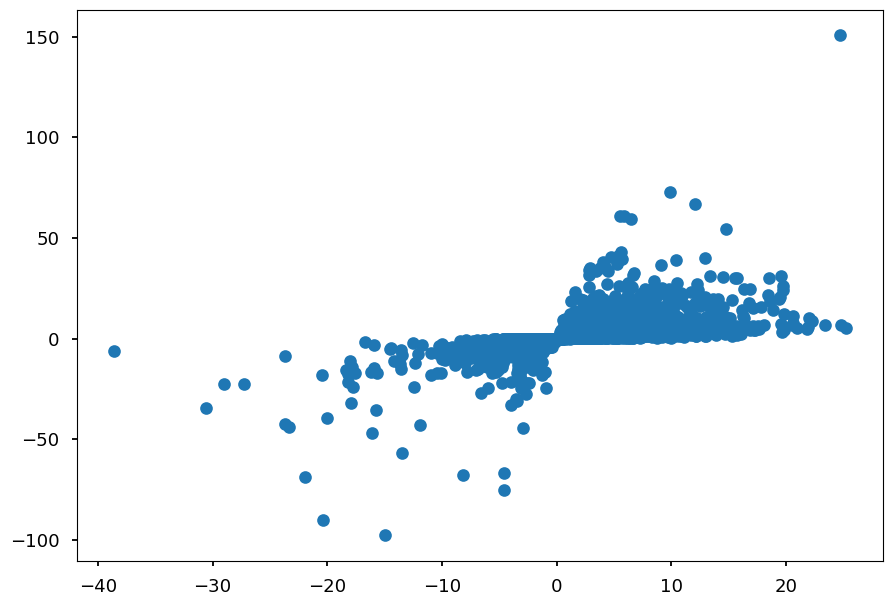

In [107]:
plt.plot(df_t_beta['t']["Q_c + Q_i + rpe"]['contra_action_value']['iti_all'], df_t_beta['beta']['Q_c + Q_i + rpe']['contra_action_value']['iti_all'], 'o')

## UnitPeriodLinearFit for all models

In [6]:
unit_to_export =  (ephys.UnitForagingQC & 'unit_minimal_session_qc = 1'
                  & histology.ElectrodeCCFPosition.ElectrodePosition    # With ccf
                  - experiment.PhotostimForagingTrial)  # Without photostim

unit_key_names = ['subject_id', 'session', 'insertion_number', 'unit']

model_order = ['dQ, sumQ, rpe', 
               'dQ, sumQ, rpe, C*2', 
               'dQ, sumQ, rpe, C*2, t', 
               'dQ, sumQ, rpe, C*2, R*1', 
               'dQ, sumQ, rpe, C*2, R*1, t',
               'dQ, sumQ, rpe, C*2, R*5, t',
               'dQ, sumQ, rpe, C*2, R*10, t',
               'contraQ, ipsiQ, rpe',
               'contraQ, ipsiQ, rpe, C*2, R*5, t']

periods = ['before_2', 'iti_all', 'go_to_end']

#### Fetch model stats (master table)
df_period_linear_fit = (psth_foraging.UnitPeriodLinearFit & unit_to_export).fetch(format='frame')

#### Fetch all params (part table)
df_period_linear_fit_params = (psth_foraging.UnitPeriodLinearFit.Param & unit_to_export).fetch(format='frame')

#### Processing master table
rel_bic = df_period_linear_fit.groupby(unit_key_names + ['period']).apply(lambda x: x.model_bic - x.query('multi_linear_model == "Q_rel + Q_tot + rpe"').model_bic.values)
df_period_linear_fit['rel_bic'] = rel_bic.values

# Discard garbage
df_period_linear_fit = df_period_linear_fit.droplevel(level=['behavior_model', 'clustering_method'], axis=0)
df_period_linear_fit.drop(columns=['actual_behavior_model'], inplace=True)

# Pivot table
df_period_linear_fit_pivot = df_period_linear_fit.unstack(level=['period', 'multi_linear_model']
                                                         ).reorder_levels([1, 2, 0], axis='columns'
                                                                      ).sort_index(axis='columns', level=[0, 1]
                                                                                  ).rename(columns={'Q_rel + Q_tot + rpe': 'dQ, sumQ, rpe',
                                                                                                             'Q_c + Q_i + rpe': 'contraQ, ipsiQ, rpe',
                                                                                                             'Q_l + Q_r + rpe': 'leftQ, rightQ, rpe',}
                                                                                          ).reindex(model_order, axis=1, level=1
                                                                                                   )
#### Processing part table
# Discard garbage
df_period_linear_fit_params = df_period_linear_fit_params.droplevel(level=['behavior_model', 'clustering_method'], axis=0)
df_period_linear_fit_params

df_period_linear_fit_params_pivot = df_period_linear_fit_params.unstack(level=['period', 'multi_linear_model', 'var_name']
                                                                       ).reorder_levels([1, 2, 0, 3], axis='columns'
                                                                                       ).rename(columns={'Q_rel + Q_tot + rpe': 'dQ, sumQ, rpe',
                                                                                                             'Q_c + Q_i + rpe': 'contraQ, ipsiQ, rpe',
                                                                                                             'Q_l + Q_r + rpe': 'leftQ, rightQ, rpe',}
                                                                                               ).reindex(model_order, axis=1, level=1
                                                                                                        )

#### Align the multi-level columns
column_level_names = ['period', 'multi_linear_model', 'stat_name', 'var_name']
df_period_linear_fit_pivot.columns = pd.MultiIndex.from_tuples([(*col, '') for col in df_period_linear_fit_pivot.columns], names=column_level_names)
df_period_linear_fit_params_pivot.columns.set_names(names=column_level_names, inplace=True)

#### Finally, merge them together
df_period_linear_fit_all = pd.concat([df_period_linear_fit_pivot, df_period_linear_fit_params_pivot], axis=1, names=column_level_names)
df_period_linear_fit_all

period                                        before_2            \
multi_linear_model                       dQ, sumQ, rpe             
stat_name                                    model_aic model_bic   
var_name                                                           
subject_id session insertion_number unit                           
473360     49      2                0          7407.63   7426.10   
                                    13         3395.90   3414.37   
                                    16         2246.13   2264.60   
                                    24         2467.70   2486.17   
                                    25         3045.54   3064.02   
...                                                ...       ...   
494691     18      3                72         2447.42   2465.31   
                                    80         3264.44   3282.33   
                                    90         3086.68   3104.57   
                                    92         3270.96   3288.85   
                                    109        3177.27   3195.16   

period                                                                         \
multi_linear_model                                                              
stat_name                                      model_p  model_r2 model_r2_adj   
var_name                                                                        
subject_id session insertion_number unit                                        
473360     49      2                0     2.169780e-01  0.005949     0.001946   
                                    13    9.924310e-02  0.008374     0.004380   
                                    16    3.732350e-01  0.004179     0.000169   
                                    24    1.216180e-01  0.007753     0.003758   
                                    25    4.489000e-01  0.003548    -0.000465   
...                                                ...       ...          ...   
494691     18      3                72    8.202310e-03  0.018129     0.013548   
                                    80    4.803620e-05  0.034568     0.030064   
                                    90    1.401300e-45  0.279660     0.276299   
                                    92    0.000000e+00  0.495436     0.493082   
                                    109   0.000000e+00  0.337576     0.334485   

period                                                                         \
multi_linear_model                               dQ, sumQ, rpe, C*2             
stat_name                                rel_bic          model_aic model_bic   
var_name                                                                        
subject_id session insertion_number unit                                        
473360     49      2                0        0.0            7398.75   7426.45   
                                    13       0.0            3389.38   3417.08   
                                    16       0.0            2242.60   2270.30   
                                    24       0.0            2468.46   2496.17   
                                    25       0.0            3041.20   3068.91   
...                                          ...                ...       ...   
494691     18      3                72       0.0            2441.17   2468.00   
                                    80       0.0            3250.72   3277.55   
                                    90       0.0            3072.14   3098.96   
                                    92       0.0            3249.47   3276.30   
                                    109      0.0            3168.47   3195.30   

period                                                        ...  \
multi_linear_model                                            ...   
stat_name                                  model_p  model_r2  ...   
var_name                                                      ...   
subject_id session insertion_number unit 

In [7]:
df_period_linear_fit_all.to_pickle(cache_folder + 'df_period_linear_fit_all.pkl')

## AOI stats

In [21]:
df_aoi = ccf.AreaOfInterest().fetch(format="frame")

In [27]:
df_aoi.loc['others']= ['', np.array([0, 0, 0], dtype=np.uint8)]
df_aoi

,full_name,rgb
area_of_interest,,
ACA,,"[64, 166, 102]"
ALM,,"[31, 157, 90]"
HY,,"[236, 70, 57]"
ILA,,"[89, 179, 99]"
LSN,,"[144, 203, 237]"
MD,,"[255, 144, 159]"
OLF,,"[139, 208, 193]"
ORB,,"[36, 138, 94]"
PALv,,"[193, 177, 216]"


In [41]:
# Add proportion of pure units
def sig_proportion(x):
    prop = sum(x) / len(x)
    ci_95 = 1.96 * np.sqrt(prop * (1 - prop) / len(x))
    return prop * 100, ci_95 * 100

for col in [c for c in df_all_unit.columns if 'pure' in c]:
    df_aoi[col] = df_all_unit.groupby('area_of_interest')[col].apply(sig_proportion)
df_aoi['number_of_units'] = df_all_unit.groupby('area_of_interest')['area_of_interest'].count()

In [42]:
df_aoi = df_aoi.reindex(['ALM', 'PL', 'ILA', 'ACA', 'ORB', 'RSP', 'VM', 'MD', 'VPM', 'HY', 'STRd', 'STRv', 'LSN', 'striatum', 'PALv', 'OLF', 'others'])
df_aoi

,full_name,rgb,pure_dQ_dQ_sumQ,pure_contraQ_dQ_sumQ,pure_sumQ_dQ_sumQ,pure_ipsiQ_dQ_sumQ,pure_ipsiQ_ipsiQ_contraQ,pure_contraQ_ipsiQ_contraQ,pure_sumQ_ipsiQ_contraQ,pure_dQ_ipsiQ_contraQ,number_of_units
area_of_interest,,,,,,,,,,,
ALM,,"[31, 157, 90]","(16.483516483516482, 2.881359108834689)","(13.814756671899527, 2.679627530925706)","(19.937205651491364, 3.1026577470986605)","(23.233908948194664, 3.2796855781851897)","(19.78021978021978, 3.093446756562172)","(30.926216640502357, 3.5892720261166753)","(10.361067503924646, 2.366665853324721)","(7.6923076923076925, 2.0693484491734337)",637
PL,,"[47, 168, 80]","(12.162162162162163, 3.330438532699505)","(18.37837837837838, 3.9464936930334584)","(32.432432432432435, 4.769953140680359)","(11.891891891891893, 3.298288370856034)","(7.297297297297297, 2.6502230528910613)","(35.4054054054054, 4.872906558577552)","(25.135135135135133, 4.420127980096588)","(4.864864864864865, 2.192103571015132)",370
ILA,,"[89, 179, 99]","(12.173913043478262, 5.976322366584793)","(20.869565217391305, 7.427379725709077)","(36.52173913043478, 8.800257623043706)","(13.043478260869565, 6.155381009950633)","(5.217391304347826, 4.064416305530248)","(40.0, 8.95391097449212)","(33.91304347826087, 8.65263552833805)","(6.086956521739131, 4.369887018029309)",115
ACA,,"[64, 166, 102]","(17.073170731707318, 3.839259875784652)","(14.363143631436316, 3.578475088511863)","(21.138211382113823, 4.165914169875531)","(16.802168021680217, 3.814885913175059)","(17.344173441734416, 3.8632821617735735)","(29.268292682926827, 4.642465163499926)","(17.88617886178862, 3.910297534716768)","(5.420054200542006, 2.310171562018457)",369
ORB,,"[36, 138, 94]","(12.213740458015266, 3.9649986295515998)","(14.885496183206106, 4.310115114172746)","(26.33587786259542, 5.33343902381134)","(19.083969465648856, 4.758357490334716)","(14.122137404580155, 4.216928675314255)","(38.16793893129771, 5.882496015076607)","(15.648854961832063, 4.399387328472255)","(3.435114503816794, 2.2053912628362715)",262
RSP,,"[26, 166, 152]","(11.11111111111111, 9.182317353970404)","(22.22222222222222, 12.147064088939171)","(11.11111111111111, 9.182317353970404)","(24.444444444444443, 12.556630129914584)","(15.555555555555555, 10.58956496487956)","(28.888888888888886, 13.24292641892925)","(15.555555555555555, 10.58956496487956)","(2.2222222222222223, 4.306888602876295)",45
VM,,"[255, 128, 132]","(18.103448275862068, 4.954793277604789)","(37.5, 6.2297084395161955)","(15.086206896551724, 4.605653160284942)","(13.36206896551724, 4.3782743292696065)","(11.637931034482758, 4.126510044952357)","(37.06896551724138, 6.215123280404574)","(23.70689655172414, 5.472579407751347)","(10.775862068965516, 3.9900585732152223)",232
MD,,"[255, 144, 159]","(6.666666666666667, 7.288238453363502)","(26.666666666666668, 12.92066580862889)","(22.22222222222222, 12.147064088939171)","(20.0, 11.6871819623989)","(17.77777777777778, 11.170771188407654)","(40.0, 14.31381616946834)","(22.22222222222222, 12.147064088939171)","(4.444444444444445, 6.021248155929235)",45
VPM,,"[255, 128, 132]","(8.88888888888889, 8.31494201008049)","(62.22222222222222, 14.165789273241433)","(20.0, 11.6871819623989)","(2.2222222222222223, 4.306888602876295)","(6.666666666666667, 7.288238453363502)","(66.66666666666666, 13.773476030955608)","(17.77777777777778, 11.170771188407654)","(2.2222222222222223, 4.306888602876295)",45


In [43]:
df_aoi.to_pickle(cache_folder + 'aoi.pkl')

### Export ccf

In [25]:
vertices, faces = ccf.AnnotatedBrainSurface.fetch1('vertices', 'faces')

In [29]:
vertices.shape

(102295, 3)

In [28]:
faces.shape

(204280, 3)

In [30]:
ccf.CCFAnnotation()

ccf_label_id Local CCF ID,ccf_x (um),ccf_y (um),ccf_z (um),annotation_version e.g. CCF_2017,annotation
0,540,3420,7820,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7840,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7860,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7880,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7900,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7920,CCF_2017,"Ventral auditory area, layer 1"
0,540,3420,7940,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7800,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7820,CCF_2017,"Ventral auditory area, layer 1"
0,540,3440,7840,CCF_2017,"Ventral auditory area, layer 1"


# Miscs

## Add `AreaOfInterest` lookup table

In [3]:
ccf.AreaOfInterest()

area_of_interest,full_name,rgb RGB color
ACA,,=BLOB=
ALM,,=BLOB=
HY,,=BLOB=
ILA,,=BLOB=
LSN,,=BLOB=
MD,,=BLOB=
OLF,,=BLOB=
ORB,,=BLOB=
PALv,,=BLOB=
PL,,=BLOB=


In [19]:
np.array([32.4, 255]).astype(np.uint8)

array([ 32, 255], dtype=uint8)

In [244]:
ImageColor.getcolor('#54BF94', "RGB")

(84, 191, 148)

In [39]:
ccf.AreaOfInterest.CCFBrainRegionIncluded()

area_of_interest,id,annotation_version e.g. CCF_2017,region_name
OLF,0,CCF_2017,Accessory olfactory bulb
OLF,1,CCF_2017,"Accessory olfactory bulb, glomerular layer"
OLF,2,CCF_2017,"Accessory olfactory bulb, granular layer"
OLF,3,CCF_2017,"Accessory olfactory bulb, mitral layer"
OLF,4,CCF_2017,accessory olfactory tract
ACA,0,CCF_2017,Anterior cingulate area
ACA,1,CCF_2017,"Anterior cingulate area, dorsal part"
ACA,2,CCF_2017,"Anterior cingulate area, dorsal part, layer 1"
ACA,3,CCF_2017,"Anterior cingulate area, dorsal part, layer 2/3"
ACA,4,CCF_2017,"Anterior cingulate area, dorsal part, layer 5"


In [ ]:
region_ann_lut = {
    # premotor
    'ALM': (["Secondary motor area%"],''),

    # isocortex, PFC
    'PL': (["Prelimbic%"],''),
    'ACA': (["Anterior cingulate area%"],''),
    'ILA': (["Infralimbic%"],''),
    'ORB': (['%orbital%'],''),
    # 'FRP': '%frontal%',
    'RSP': (["Retrosplenial area%"],''),

    # thalamus
    'VM': (['Ventral medial%'],''),
    'MD': (['Mediodorsal%'],''),
    'VPM': (['Ventral posteromedial%'],''),
    'HY': (['Hypothalamus', 'Zona %'],''),

    # striatum
    'LSN': (["Lateral septal nucleus%"],''),
    'STRd': (["Caudoputamen%"],''),
    'STRv': (["Nucleus accumbens%", "Fundus%"],''),
    'striatum': (["striatum%"],''),

    # Pallidum
    'PALv': (["Substantia innominata%", "Magnocellular%"],''),

    # Olfactory
    'OLF': (["%olfactory%"],''),
}